In [16]:
%matplotlib widget
import numpy as np
import pandas as pd
import scipy
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(0)
plt.style.use('fivethirtyeight')

In [ ]:
demographics_df = (
    pd.read_csv("demographics.csv")
    .assign(gender_ratio=lambda x: x.male / x.female)
    .drop(columns=["male", "female"])
)
features = [
    "hispanic_latino",
    "white",
    "black",
    "native_american",
    "asian",
    "nhpi",
    "other_race",
    "two_or_more",
    "income",
    "foreign_born",
    "gender_ratio",
    "bachelors",
    "median_age",
]
X = demographics_df[features]
y = demographics_df["margin"]
features

[0.02932229830648987, 0.013168326460651759, 2.996563132930468e-27, 9.495495638626493e-26, 9.844328684114801e-24, 1.0728540988295906e-21, 3.687094095343404e-19, 2.876972109369288e-17, 8.743825706142246e-15, 1.7895413126379782e-08]
[0.048943986323891873, 0.0788173626345858, 0.5450167728146349, 0.35603456949837226, 0.42746533746871085, 0.5245849312848205, 0.573531038536465, 0.5940637415432769, 0.5544176433983868, 0.6705040073319107]


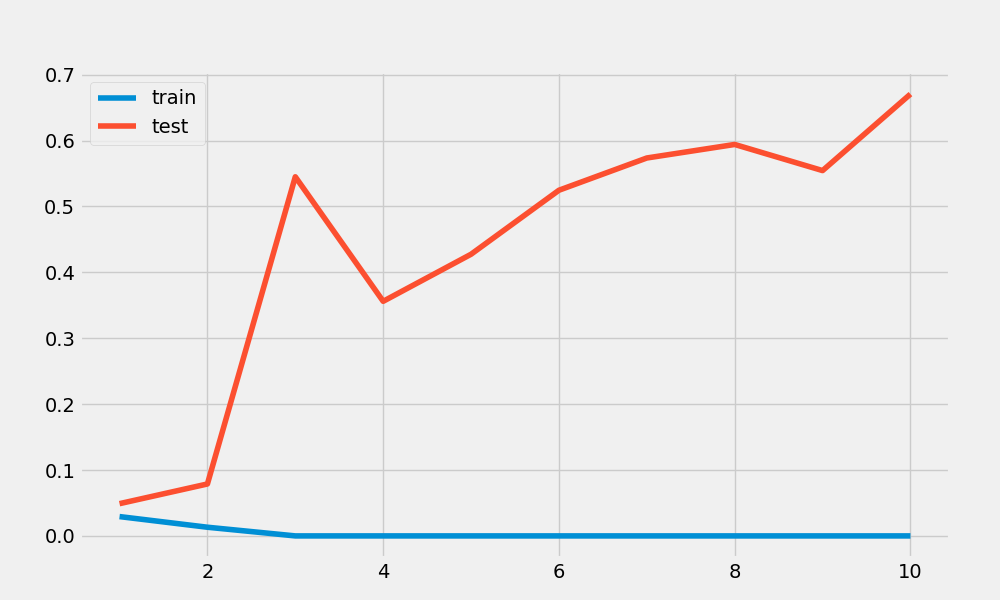

In [20]:
X_standardized = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, random_state=0)

test_r_squares = []
train_r_squares = []

for i in range(1, 11):
    model = Pipeline([('poly', PolynomialFeatures(i)), ('ridge', LinearRegression())])
    model.fit(X_train, y_train)

    train_r_squares.append(mean_squared_error(y_train, np.clip(model.predict(X_train), -1, 1)))
    test_r_squares.append(mean_squared_error(y_test, np.clip(model.predict(X_test), -1, 1)))

print(train_r_squares)
print(test_r_squares)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, 11), train_r_squares, label="train")
ax.plot(range(1, 11), test_r_squares, label="test")
ax.legend()